In [1]:
import numpy as np
import os
from collections.abc import Callable
import Levenshtein
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import scipy as sp

### Sequence distance

In [146]:
def sequence_distance_matrix(query_seqs: np.array,
                             reference_seqs: np.array,
                             measure: Callable = Levenshtein.distance):
    
    # Check equal amounts of sequence subsets
    if len(query_seqs.shape) == 2:
        assert query_seqs.shape[1] == reference_seqs.shape[1], "Input arrays must have same second dimension, i.e. number of subsequences."
    assert len(query_seqs.shape) <= 2, "Input sequence arrays must be of dimension [n,m], where n is number of sequence sets and m number of subsequences."
    
    # Find unique sequences and their indices
    unique_query_seqs, query_idx = np.unique(query_seqs, return_inverse=True)
    unique_reference_seqs, reference_idx = np.unique(reference_seqs, return_inverse=True)
    
    # Initialize unique distance matrix
    q = len(unique_query_seqs)
    r = len(unique_reference_seqs)
    unique_distance_matrix = np.zeros((q, r))
    
    for i, q_seq in tqdm(enumerate(unique_query_seqs), total=q):
        for j, r_seq in enumerate(unique_reference_seqs):
            unique_distance_matrix[i, j] = measure(q_seq, r_seq)
    
    return unique_distance_matrix[np.reshape(query_idx, query_seqs.shape)[:,None],
                                  np.reshape(reference_idx[None,:], reference_seqs.shape)]
    

In [ ]:
# Loading test data set
testdata = pd.read_csv('test-data/LAMP2 R2+ Lib1A.tsv', sep='\t')
testdata = testdata[testdata['Count'] > 2]
testdata

,Framework,CDRL1,CDRL2,CDRL3,CDRH1,CDRH2,CDRH3,Count
0,Library_1A,QTIGSA,DASTLTS,EQTYITPRT,GGTFTNHP,INPSSGST,ARGPGMDV,316
1,Library_1A,QTISPY,HASILQS,QQYDRYSLT,GGTFRDYA,IRPTSGGT,ATVGSGWYTYFDY,242
2,Library_1A,QSLGSH,SASTLQK,QQSHIMPVT,GYPFTSYH,INPDAGTT,ARDDAFDI,200
3,Library_1A,QTIGND,GTSNLQD,LQTYTAPHT,GYPFTNHY,INPKTGTT,ARDYGMDV,196
4,Library_1A,QNINRN,AASKLEA,QHTYNIPYT,GYPFTSHY,LNPSGGSP,AKDDSHPMVRGPRGAFDI,194
...,...,...,...,...,...,...,...,...
2767,Library_1A,HGVSSY,SASKLQS,QQYHTLPPT,GGTFSIYP,INAGTGTT,ASFDSSALDY,3
2768,Library_1A,EGIGTY,GAFNLPI,QQSNRFPYT,GYAFTTNA,INAYSGGT,ARERYGSGWYVWYYYGMDV,3
2769,Library_1A,QDISYS,DAYNLEA,QQYVTSFPT,GGAFRNYA,INPQSGAT,ARGNAFDY,3
2770,Library_1A,QDVSGF,GASSLYN,QQYSTYAGT,GGSFRNYA,INVRGGST,ARGQGAYYDILTGDFDY,3


In [286]:
# Calculating edit distances
cdrs = testdata.iloc[:,1:7].values
dists = sequence_distance_matrix(cdrs, cdrs)

100%|██████████| 10144/10144 [00:24<00:00, 409.34it/s]


In [296]:
# Plotting distribution of edit distances
df_dists = (
    pd.DataFrame(dists[0 == np.tri(*dists.shape[:2])],
                columns=testdata.columns[1:7])
    .melt(var_name='CDR', value_name='Distance')
)

df_dists['Chain'] = df_dists['CDR'].str[-2]
df_dists['CDR#'] = df_dists['CDR'].str[-1]

#sns.displot(    
#    df_dists,
#    x='Distance',
#    row='Chain',
#    col='CDR#',
#    binwidth=1
#)

100%|██████████| 2772/2772 [00:00<00:00, 112846.85it/s]


(0.0, 2209.2)

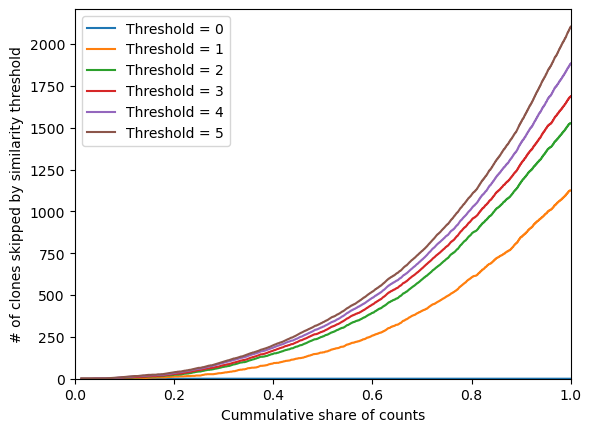

In [297]:
# Determining thresholds for edit distance

# Calculating minimum edit distance for each sequence
cum_min_distance = np.zeros(len(testdata))
for i in tqdm(range(len(testdata))):
    if i == 0:
        cum_min_distance[i] = np.inf
        continue
    # Determine minimum edit distance amongst sequences with higher abundance than the subject
    cum_min_distance[i] = dists[i,:i,-1].min()

# Plotting skipping frequency as a function of edit distance thresholds
for t in range(6):
    plt.plot(testdata['Count'].cumsum() / testdata['Count'].sum(), (cum_min_distance < t).cumsum(), label = f'Threshold = {t}')

plt.legend()

plt.xlabel('Cummulative share of counts')
plt.ylabel('# of clones skipped by similarity threshold')

plt.xlim(0,1)
plt.ylim(0)

(0.0, 2209.2)

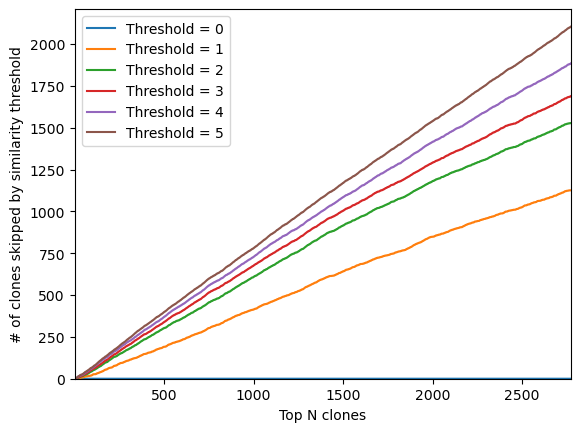

In [298]:
# Plotting skipping frequency as a function of edit distance thresholds
for t in range(6):
    plt.plot(np.arange(cum_min_distance.shape[0]) + 1, (cum_min_distance < t).cumsum(), label = f'Threshold = {t}')

plt.legend()

plt.xlabel('Top N clones')
plt.ylabel('# of clones skipped by similarity threshold')

plt.xlim(1, cum_min_distance.shape[0])
plt.ylim(0)

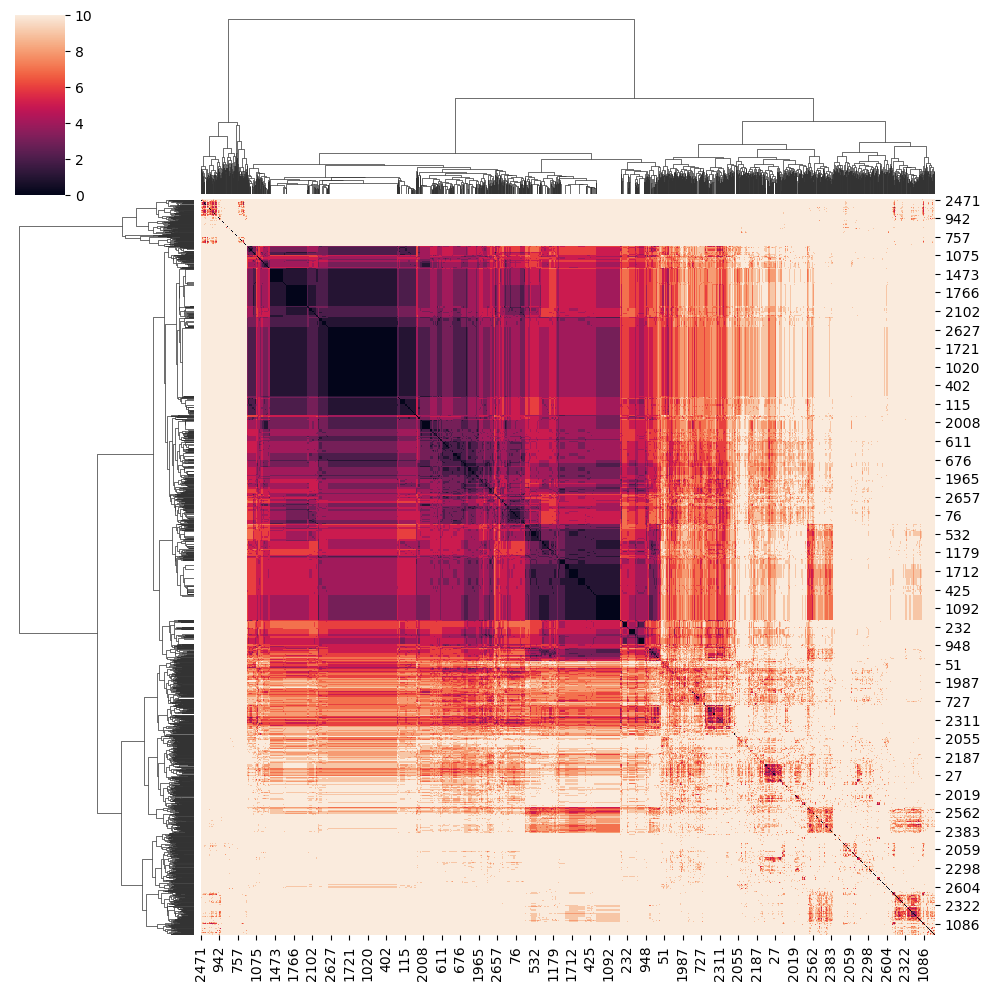

In [299]:
# Clustered heatmap based on CDRH3 edit distances
#sns.clustermap(dists[:,:,-1], vmin=0, vmax=10)

### Convergence of rank-order measures

In [ ]:
def kendalls_tau(rank_orders):
    """Computes Kendall's Tau between consecutive sampling depths."""
    taus = []
    for i in range(len(rank_orders) - 1):
        tau, _ = sp.stats.kendalltau(rank_orders[i], rank_orders[i + 1])
        taus.append(tau)
    return taus

def spearmans_rho(rank_orders):
    """Computes Spearman's Rank Correlation between consecutive sampling depths."""
    rhos = []
    for i in range(len(rank_orders) - 1):
        rho, _ = sp.stats.spearmanr(rank_orders[i], rank_orders[i + 1])
        rhos.append(rho)
    return rhos

def jaccard_similarity(rank_orders, k):
    """Computes Jaccard similarity of the top-k ranked categories at consecutive depths."""
    jaccard_scores = []
    for i in range(len(rank_orders) - 1):
        top_k_1 = set(rank_orders[i][:k])
        top_k_2 = set(rank_orders[i + 1][:k])
        jaccard = len(top_k_1 & top_k_2) / len(top_k_1 | top_k_2)
        jaccard_scores.append(jaccard)
    return jaccard_scores


#### Jaccard similarity
"*How many of the Abs in the top K are consistently there?*"

100%|██████████| 70000/70000 [01:48<00:00, 644.31it/s] 


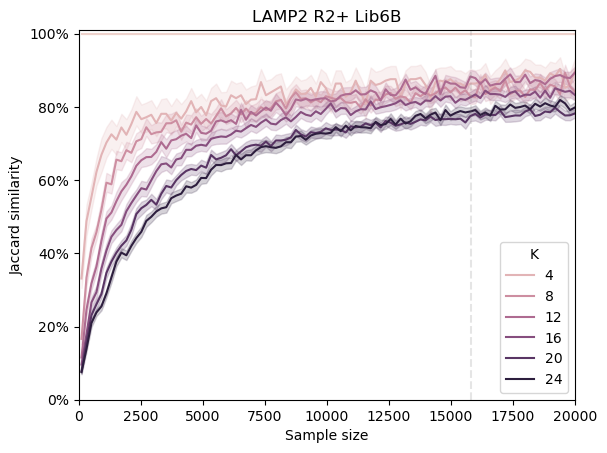

In [36]:
# Jaccard similarity
k_n = 7
sample_size_n = 100
simulations_n = 100
        
# Looping over samples
for sequencing_sample in sorted(os.listdir('test-data')):
    
    if not sequencing_sample[:-4] == 'LAMP2 R2+ Lib6B':
        continue
    
    df = pd.read_csv(os.path.join('test-data', sequencing_sample), sep='\t')
    counts = df.groupby('CDRH3')['Count'].sum().sort_values(ascending=False)

    # Looping over k-values
    jaccard_similarities = pd.Series()
    with tqdm(total = k_n * sample_size_n * simulations_n) as tbar:
        for k in np.linspace(1,24,k_n):
            k = int(k)
            top_k_true = set(counts.nlargest(k).index)
            
            # Looping over sample sizes
            jaccard_similarities[k] = pd.Series()
            
            for sample_size in np.linspace(100,20000,sample_size_n):
                sample_size = round(sample_size)
                jaccard_similarities[k][sample_size] = []
                
                # Repeating simulations
                for _ in range(simulations_n):
                    sample = np.random.choice(counts.index, sample_size, p=counts/counts.sum())
                    sample_counts = pd.Series(sample).value_counts(ascending=False)
                    
                    top_k_sample = set(sample_counts.nlargest(k).index)
                    jaccard_similarities[k][sample_size].append( len(top_k_true & top_k_sample) / len(top_k_true | top_k_sample) )
                    
                    tbar.update(1)
            
            # Wrangling data
            jaccard_similarities[k] = (
                jaccard_similarities[k]
                .explode()
                .rename('Jaccard similarity')
                .rename_axis('Sample size')
                .reset_index())
            jaccard_similarities[k]['K'] = k
        
    jaccard_similarities = pd.concat(jaccard_similarities.to_list())
    
    # Plotting
    sns.lineplot(
        jaccard_similarities,
        x='Sample size',
        y='Jaccard similarity',
        hue='K',
        #alpha=0.1, s=4
        )
    plt.ylim(0,1.01)
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    plt.vlines(counts.sum(),*plt.ylim(),linestyles='--', colors='grey', alpha=0.2)
    plt.xlim(0, jaccard_similarities['Sample size'].max())
    plt.title(sequencing_sample[:-4])
    plt.show()    


In [ ]:
import emcee
import numpy as np
import scipy.optimize as opt

# Define the function to fit
def J_func(d, J_inf, d_half):
    return J_inf * d / (d + d_half)

# Define the log-likelihood function
def log_likelihood(theta, d, J_obs, J_err):
    J_inf, d_half = theta
    model = J_func(d, J_inf, d_half)
    return -0.5 * np.sum(((J_obs - model) / J_err) ** 2)

# Define the log-prior function
def log_prior(theta):
    J_inf, d_half = theta
    if 0 <= J_inf <= 1 and d_half > 0:
        return np.log(2 * J_inf)  # Triangular prior
    return -np.inf  # Reject values outside bounds

# Define the posterior probability function
def log_posterior(theta, d, J_obs, J_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, d, J_obs, J_err)

100%|██████████| 5000/5000 [03:34<00:00, 23.32it/s]

Bayesian Fitted J_inf: 0.8988, d_half: 2304.1251


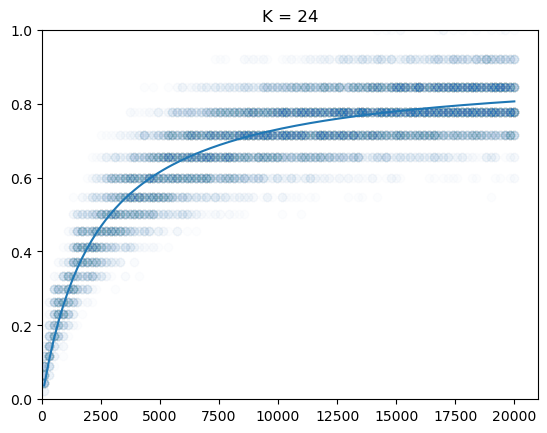

100%|██████████| 5000/5000 [03:34<00:00, 23.27it/s]

Bayesian Fitted J_inf: 0.8536, d_half: 1650.3146


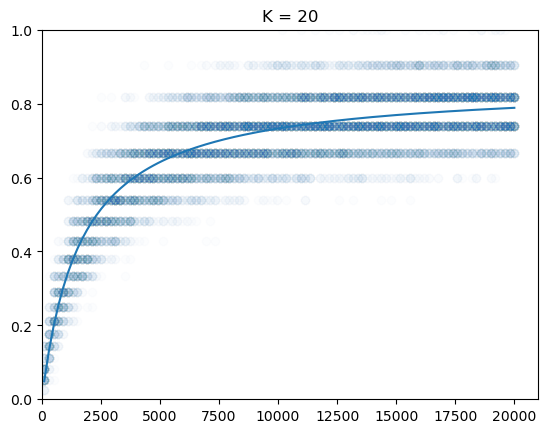

100%|██████████| 5000/5000 [03:35<00:00, 23.22it/s]


Bayesian Fitted J_inf: 0.8978, d_half: 1399.0811


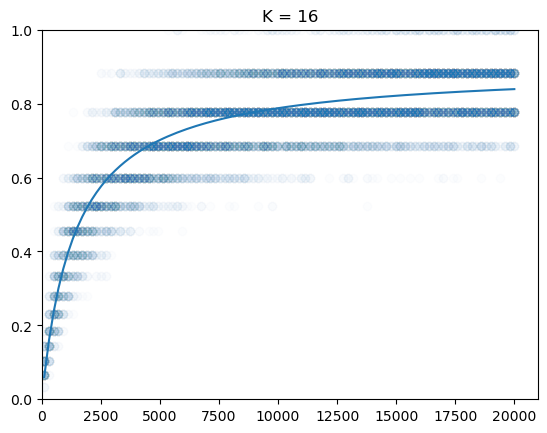

100%|██████████| 5000/5000 [03:34<00:00, 23.29it/s]

Bayesian Fitted J_inf: 0.9149, d_half: 1058.9761


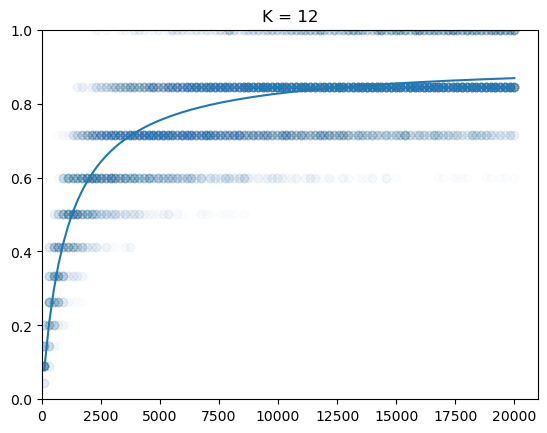

  5%|▍         | 232/5000 [00:10<03:27, 22.94it/s]Traceback (most recent call last):
  File "/opt/anaconda3/envs/epibio/lib/python3.11/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/t5/dd7qm57d3cxdtvhqgdwz92cm0000gn/T/ipykernel_1725/4121469395.py", line 27, in log_posterior
    return lp + log_likelihood(theta, d, J_obs, J_err)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/t5/dd7qm57d3cxdtvhqgdwz92cm0000gn/T/ipykernel_1725/4121469395.py", line 13, in log_likelihood
    return -0.5 * np.sum(((J_obs - model) / J_err) ** 2)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/epibio/lib/python3.11/site-packages/numpy/core/fromnumeric.py", line 2172, in _sum_dispatcher
    def _sum_dispatcher(a, axis=None, dtype=None, out=None, keepdims=None,
    
KeyboardInterrupt
  5%|▍         | 233/5000 [00:10<03:28, 

emcee: Exception while calling your likelihood function:
  params: [  0.86674054 562.17469257]
  args: (array([100, 100, 100, ..., 20000, 20000, 20000], dtype=object), array([0.14285714285714285, 0.14285714285714285, 0.06666666666666667, ...,
       0.7777777777777778, 1.0, 0.7777777777777778], dtype=object), 0.05)
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [47]:
# Fitting saturation curve for each K
for K in jaccard_similarities['K'].drop_duplicates().sort_values(ascending=False):
        
    d_values = jaccard_similarities[jaccard_similarities['K'] == K].values[:,0]
    J_values = jaccard_similarities[jaccard_similarities['K'] == K].values[:,1]

    # Set up MCMC
    ndim, nwalkers = 2, 50
    pos = np.array([np.random.uniform(0.1, 1), np.random.uniform(0.1, 10)]) + 1e-4 * np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(d_values, J_values, 0.05))

    # Run MCMC
    sampler.run_mcmc(pos, 5000, progress=True)

    # Extract results
    samples = sampler.get_chain(discard=1000, thin=10, flat=True)
    J_inf_mcmc, d_half_mcmc = np.median(samples, axis=0)

    print(f"Bayesian Fitted J_inf: {J_inf_mcmc:.4f}, d_half: {d_half_mcmc:.4f}")
    
    plt.title(f'K = {K}')
    plt.plot(d_values, J_func(d_values, J_inf_mcmc, d_half_mcmc))
    plt.xlim(0)
    plt.ylim(0,1)
    plt.scatter(d_values, J_values, alpha=0.01)
    plt.show()


### Convergence of diversity measures

In [300]:
def N_x(counts, x=0.5) -> int:
    counts = pd.Series(counts)
    return (counts.sort_values(ascending=False).cumsum() <= (counts.sum() * x)).sum()

In [301]:
def gini_index(counts) -> int:
    counts = np.array(counts, dtype=np.float64)
    counts.sort()
    n = len(counts)
    cumulative_sum = np.cumsum(counts)
    total = cumulative_sum[-1]
    gini = (2 * np.sum((np.arange(1, n + 1) * counts).sum()) - (n + 1) * total) / (n * total)
    return gini

Gini coefficient    N 1/2  Normalized N 1/2  \
Target Library Round Selection                                                
LAMP1  1A      R2    +                  0.622015    291.0          0.008332   
               R3    +                  0.662256     17.0          0.003120   
       4A      R2    +                  0.639448     43.0          0.002085   
               R3    +                  0.948618      7.0          0.002585   
       6B      R2    +                  0.226449  10236.0          0.303011   
               R3    +                  0.926666      3.0          0.000679   
       8B      R2    +                  0.888841      6.0          0.001141   
               R3    +                  0.946853      2.0          0.001086   
LAMP2  1A      R2    +                  0.603161    713.0          0.029463   
                     -                  0.539556    195.0          0.092373   
       4A      R2    +                  0.562329   1183.0          0.117840   
                     -                  0.233330    999.0          0.306442   
       6B      R2    +                  0.446777   1174.0          0.147506   
                     -                  0.262653    546.0          0.268569   
       8B      R2    +                  0.554712    847.0          0.112126   
                     -                  0.287799    597.0          0.261384   
MRC2   1A      R3    +                  0.964091      3.0          0.001221   
RNF128 1A      R2    +                  0.207307  37451.0          0.355221   
               R3    +                  0.714322    715.0          0.035986   
cyIgG4 1A      R2    A+                 0.865809     44.0          0.006742   
                     B+                 0.852252    111.0          0.015878   
       4A      R2    A+                 0.915910      9.0          0.002128   
                     B+                 0.932876      4.0          0.000837   
       6B      R2    A+                 0.927867      8.0          0.003628   
                     B+                 0.949616      1.0          0.000347   
       8B      R2    A+                 0.895359     21.0          0.005354   
                     B+                 0.886102     20.0          0.005942   

                                Sample size  
Target Library Round Selection               
LAMP1  1A      R2    +              98909.0  
               R3    +              17673.0  
       4A      R2    +              58791.0  
               R3    +              66383.0  
       6B      R2    +              47090.0  
               R3    +              68031.0  
       8B      R2    +              51312.0  
               R3    +              42528.0  
LAMP2  1A      R2    +              66369.0  
                     -               5614.0  
       4A      R2    +              39453.0  
                     -               4521.0  
       6B      R2    +              15813.0  
                     -               2996.0  
       8B      R2    +              25588.0  
                     -               3559.0  
MRC2   1A      R3    +             104335.0  
RNF128 1A      R2    +             135957.0  
               R3    +              98437.0  
cyIgG4 1A      R2    A+             76576.0  
                     B+             71106.0  
       4A      R2    A+             62524.0  
                     B+             82196.0  
       6B      R2    A+             47276.0  
                     B+             78092.0  
       8B      R2    A+             52681.0  
                     B+             39430.0

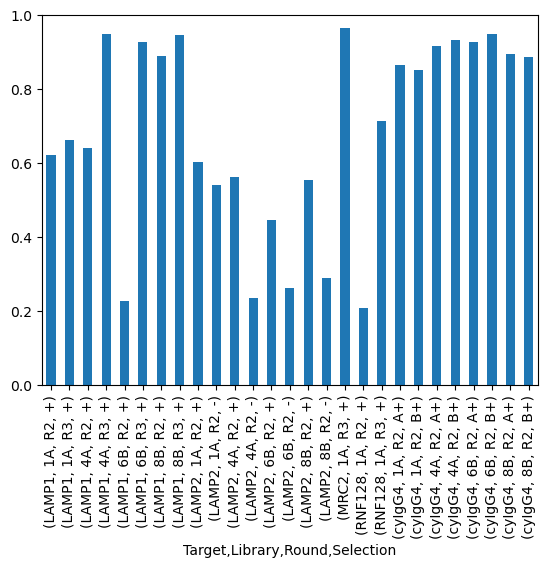

In [324]:
gis = pd.DataFrame()
for sample in os.listdir('test-data'):
    df = pd.read_csv(os.path.join('test-data', sample), sep='\t')
    counts = df.groupby('CDRH3')['Count'].sum()
    sample = sample.replace('.tsv', '')
    gis.loc[sample, 'Gini coefficient'] = gini_index(counts)
    gis.loc[sample, 'N 1/2'] = N_x(counts, 0.5)
    gis.loc[sample, 'Normalized N 1/2'] = N_x(counts, 0.5) / len(counts)
    gis.loc[sample, 'Sample size'] = counts.sum()
gis['Target'] = gis.index.map(lambda idx: idx.split(' ')[0])
gis['Library'] = gis.index.map(lambda idx: idx.split(' ')[2][-2:])
gis['Round'] = gis.index.map(lambda idx: idx.split(' ')[1][:2])
gis['Selection'] = gis.index.map(lambda idx: idx.split(' ')[1][2:])
gis = gis.set_index(['Target', 'Library', 'Round', 'Selection']).sort_index()
gis['Gini coefficient'].plot.bar()
plt.ylim(0,1)
gis

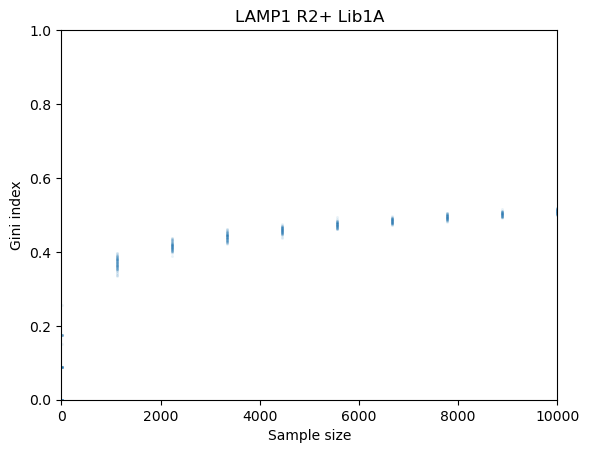

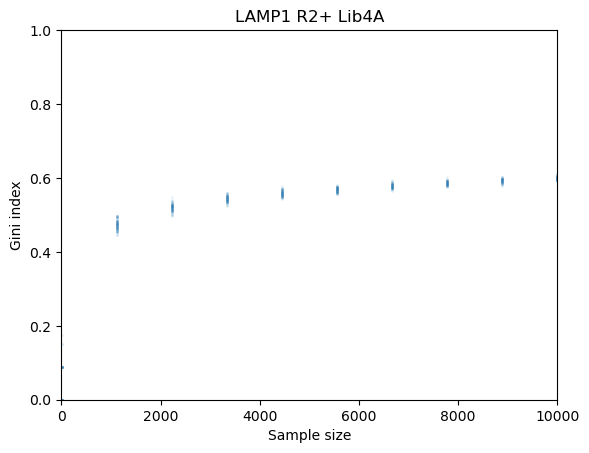

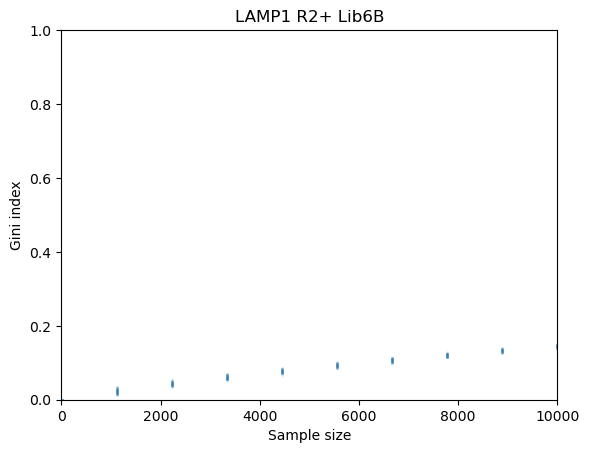

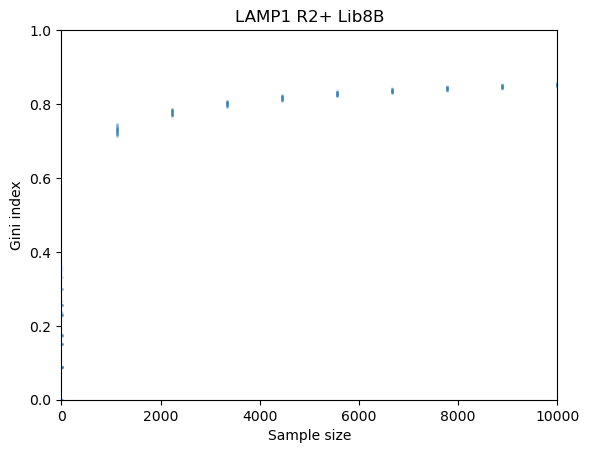

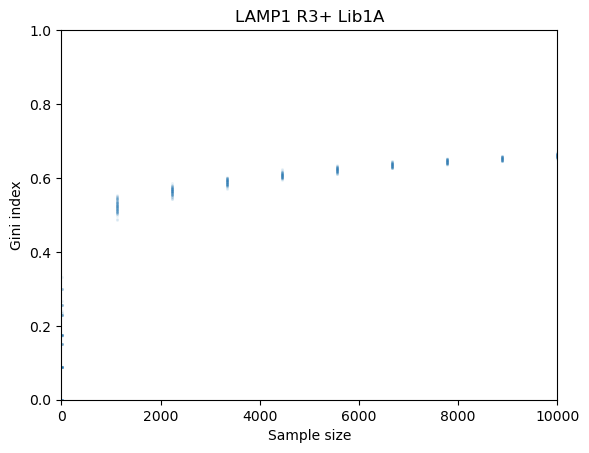

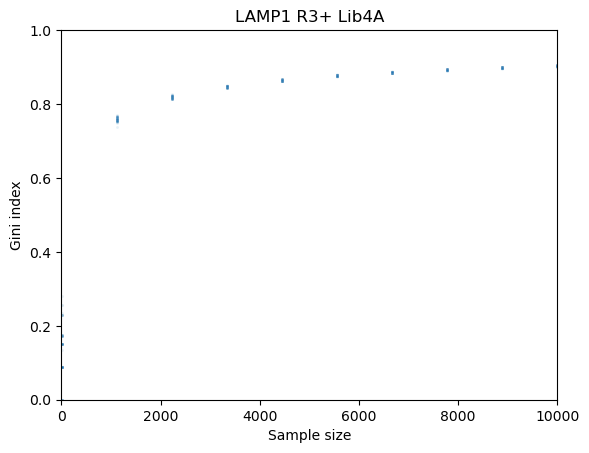

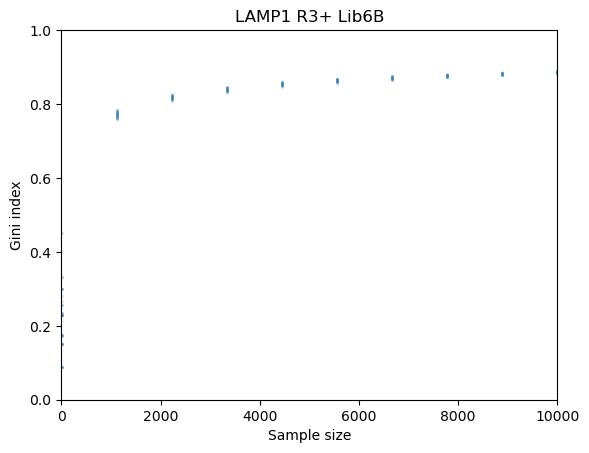

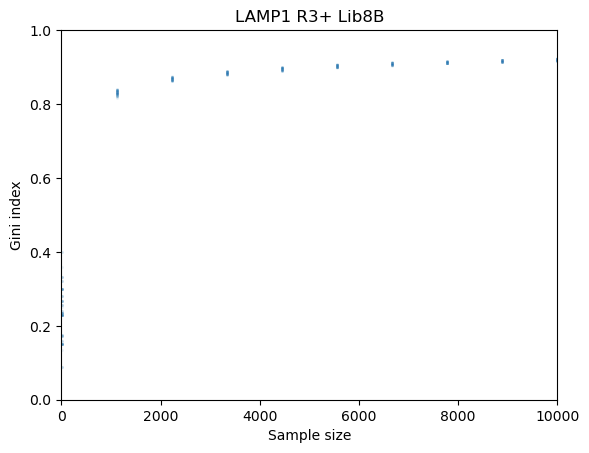

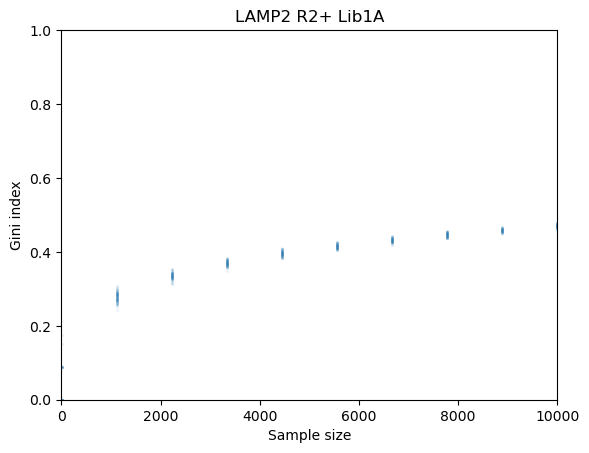

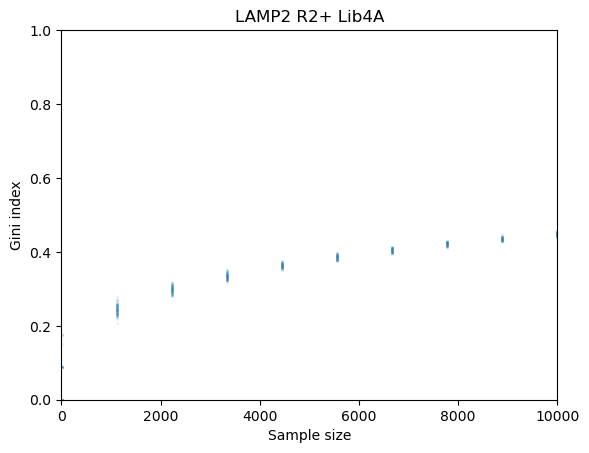

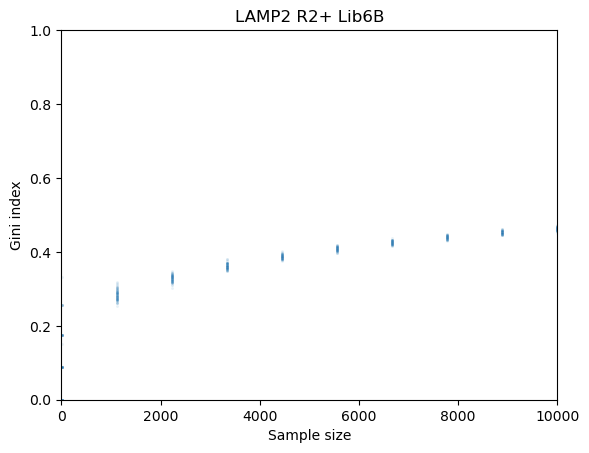

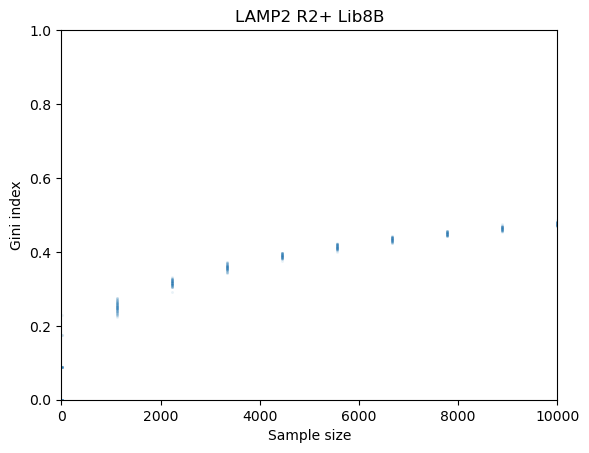

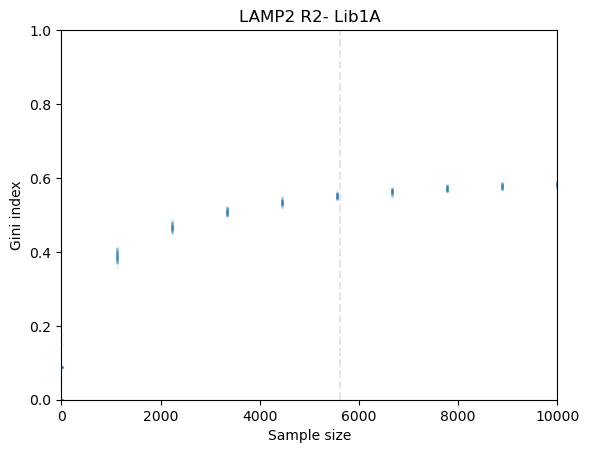

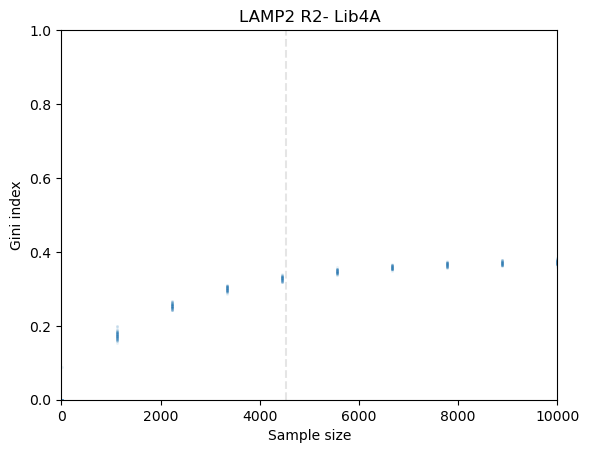

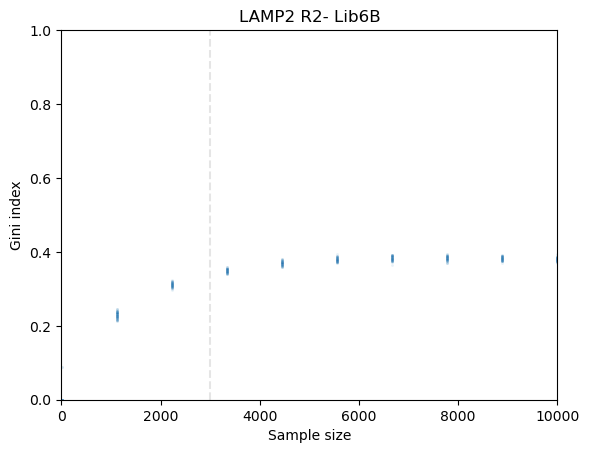

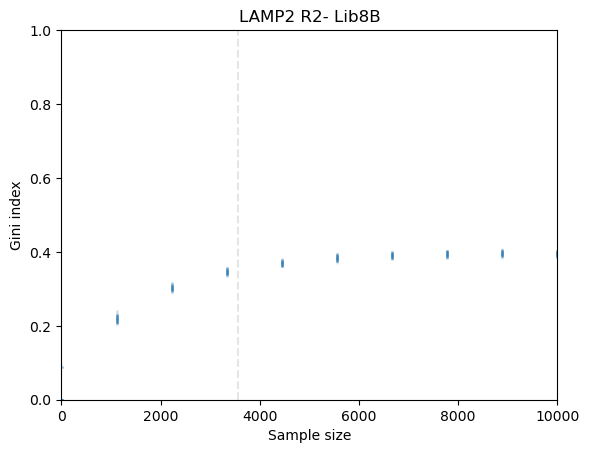

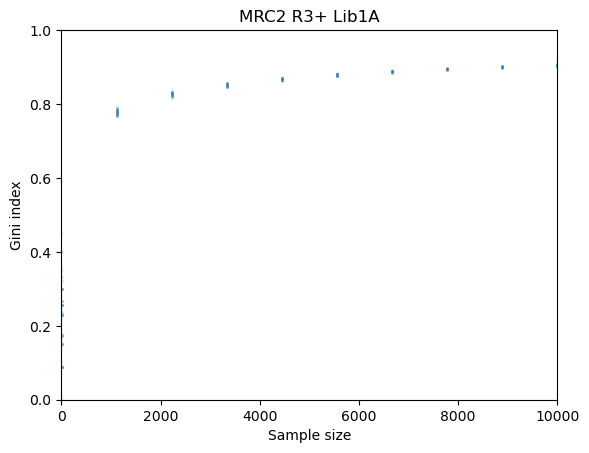

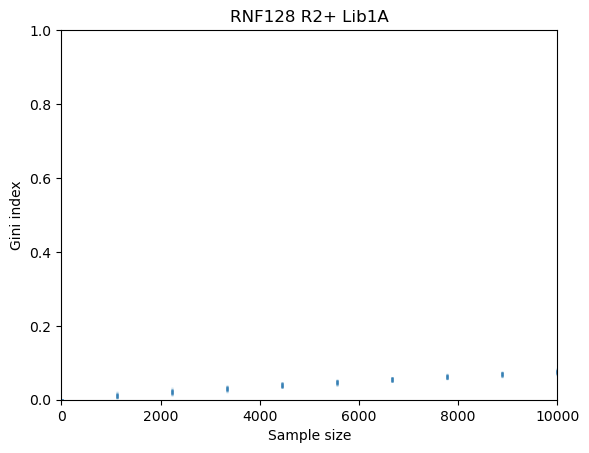

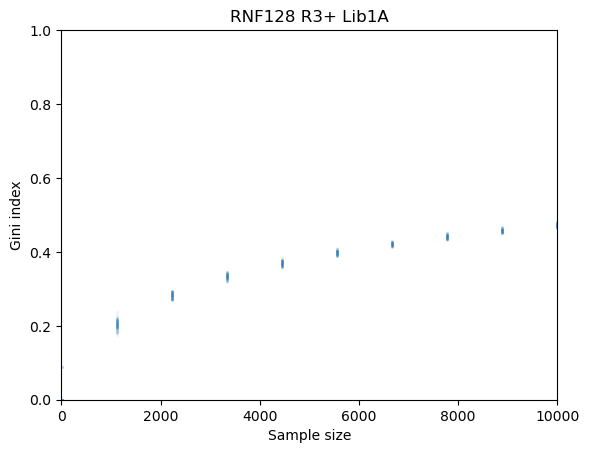

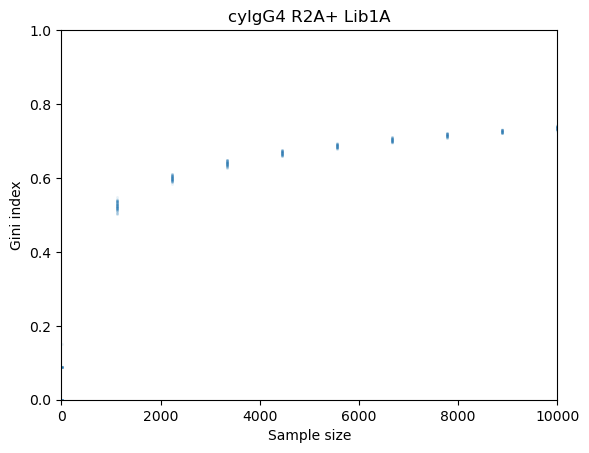

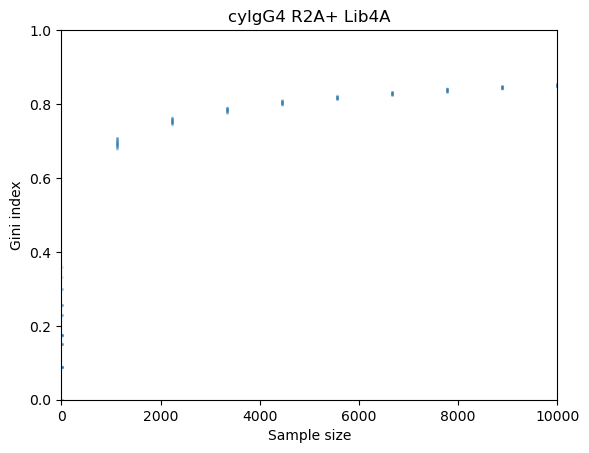

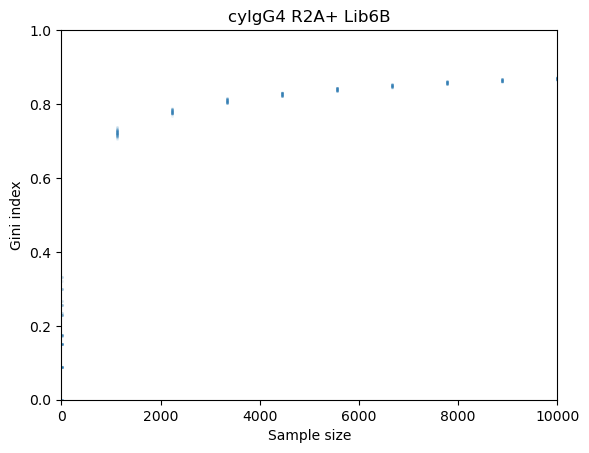

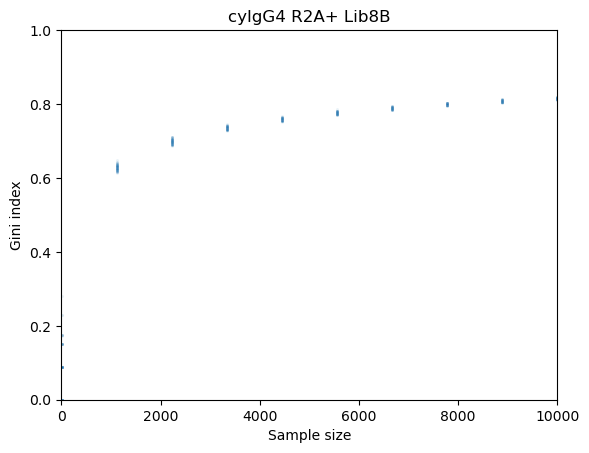

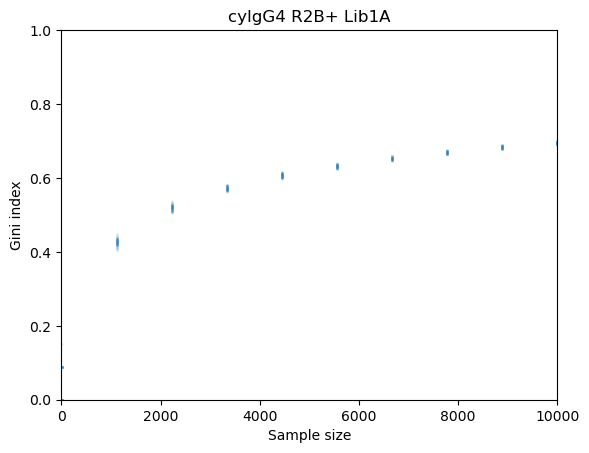

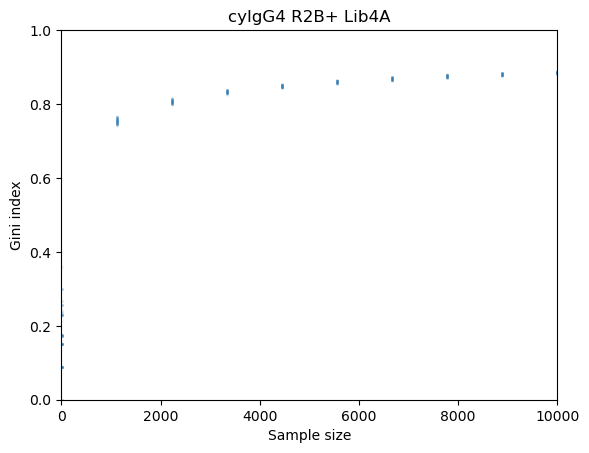

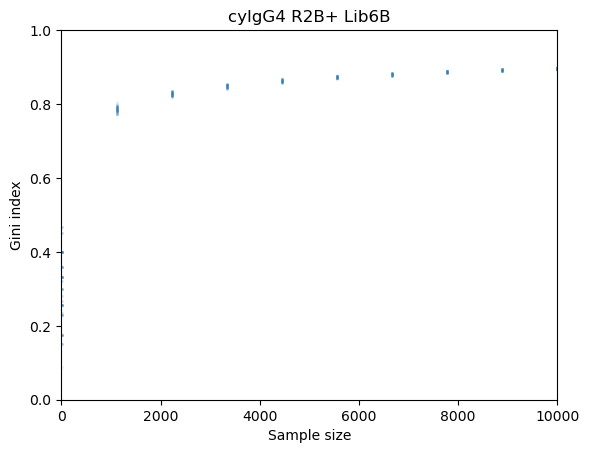

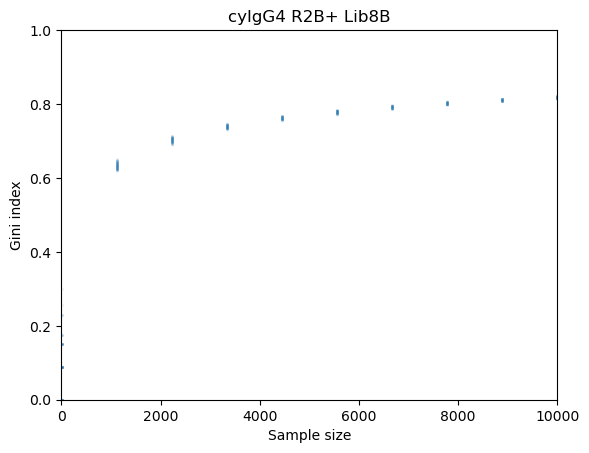

In [349]:
for sequencing_sample in sorted(os.listdir('test-data')):
    df = pd.read_csv(os.path.join('test-data', sequencing_sample), sep='\t')
    counts = df.groupby('CDRH3')['Count'].sum()

    # Checking convergence of Gini index
    gini_indices = pd.Series()
    for sample_size in np.linspace(10,10000,10):
        sample_size = round(sample_size)
        gini_indices[sample_size] = []
        for _ in range(100):
            sample = np.random.choice(counts.index, sample_size, p=counts/counts.sum())
            __, _counts = np.unique(sample, return_counts=True)
            gini_indices[sample_size].append(gini_index(_counts))
            
    sns.scatterplot((
            gini_indices
            .explode()
            .rename('Gini index')
            .rename_axis('Sample size')
            .reset_index()),
        x='Sample size',
        y='Gini index',
        alpha=0.1, s=4)
    plt.vlines(counts.sum(),0,1,linestyles='--', colors='grey', alpha=0.2)
    plt.ylim(0,1)
    plt.xlim(0,10000)
    plt.title(sequencing_sample[:-4])
    plt.show()


(0.0, 1.0)

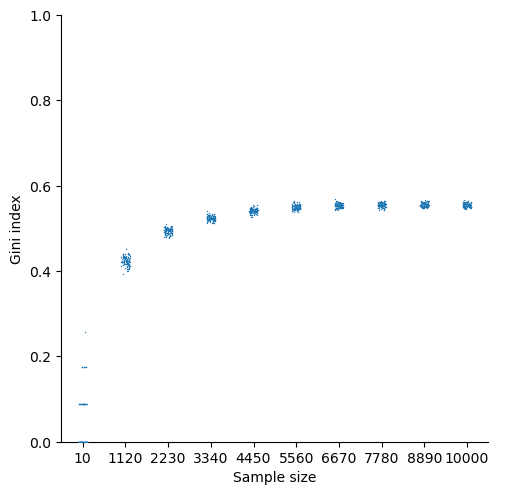

In [318]:
testdata = pd.read_csv('test-data/LAMP2 R2+ Lib8B.tsv', sep='\t')
testdata = testdata[testdata['Count'] > 2]

# Checking convergence of Gini index
subjects = testdata.index
weights = testdata.Count

gini_indices = pd.Series()
for sample_size in np.linspace(10,10000,10):
    sample_size = round(sample_size)
    gini_indices[sample_size] = []
    for _ in range(100):
        sample = np.random.choice(subjects, sample_size, p=weights/weights.sum())
        __, counts = np.unique(sample, return_counts=True)
        gini_indices[sample_size].append(gini_index(counts))
        
sns.catplot((
        gini_indices
        .explode()
        .rename('Gini index')
        .rename_axis('Sample size')
        .reset_index()),
    x='Sample size',
    y='Gini index',
    s=1)
plt.ylim(0,1)

In [392]:
for sequencing_sample in sorted(os.listdir('test-data')):
    if 'R2' in sequencing_sample:
        continue
    if '-' in sequencing_sample:
        continue
    df = pd.read_csv(os.path.join('test-data', sequencing_sample), sep='\t')
    counts = df.groupby('CDRH3')['Count'].sum()

    # Checking convergence of Gini index
    Nx_indices = pd.Series()
    for sample_size in np.linspace(10,10000,100):
        sample_size = round(sample_size)
        Nx_indices[sample_size] = []
        for _ in range(20):
            sample = np.random.choice(counts.index, sample_size, p=counts/counts.sum())
            __, _counts = np.unique(sample, return_counts=True)
            Nx_indices[sample_size].append(N_x(_counts, 0.50))
            
    sns.scatterplot((
            Nx_indices
            .explode()
            .rename('$N_{50\%}$')
            .rename_axis('Sample size')
            .reset_index()),
        x='Sample size',
        y='$N_{50\%}$',
        alpha=0.1, s=4)
    plt.ylim(0)
    plt.vlines(counts.sum(),*plt.ylim(),linestyles='--', colors='grey', alpha=0.2)
    plt.xlim(0,10000)
    plt.title(sequencing_sample[:-4])
    plt.show()


KeyboardInterrupt: 